# Logistic Regression

In this example, we will explore linear classifier using a dataset which deals with muchrooms properties and if they are poisonous or edible.

You can find the initial exercise on OpenClassRoom : https://openclassrooms.com/fr/courses/4444646-entrainez-un-modele-predictif-lineaire/4507851-tp-entrainez-une-regression-logistique-et-une-svm-lineaire

In [24]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, svm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.exceptions import ConvergenceWarning
from pylab import *

In [6]:
from warnings import simplefilter
# ignore all future warnings
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

In [7]:
df = pd.read_csv("Mushrooms.csv")
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


Here, we want to predict if a mushroom is edible "e" or poisonous "p" following the first column "class".

As we can clearly see, our variables are mainly categorical since they are letters which represents some properties of the mushroom

## I - Exploring data And preprocessing

In [8]:
df.describe()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,...,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


In [9]:
print("dataset size : {}".format(df.shape[0]))

dataset size : 8124


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
class                       8124 non-null object
cap-shape                   8124 non-null object
cap-surface                 8124 non-null object
cap-color                   8124 non-null object
bruises                     8124 non-null object
odor                        8124 non-null object
gill-attachment             8124 non-null object
gill-spacing                8124 non-null object
gill-size                   8124 non-null object
gill-color                  8124 non-null object
stalk-shape                 8124 non-null object
stalk-root                  8124 non-null object
stalk-surface-above-ring    8124 non-null object
stalk-surface-below-ring    8124 non-null object
stalk-color-above-ring      8124 non-null object
stalk-color-below-ring      8124 non-null object
veil-type                   8124 non-null object
veil-color                  8124 non-null object
ring-number

Since our variables can't be used in a model, we will convert them as categorical data :
we will choose the label encoder

In [11]:
# label encoder
labelencoder=LabelEncoder()
df_label = pd.DataFrame()
for col in df.columns:
    df_label[col] = labelencoder.fit_transform(df[col])
df_label.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,5,2,4,1,6,1,0,1,4,...,2,7,7,0,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1


## II - Training Logistic Regression

In [12]:
Y = pd.DataFrame(df_label["class"])
X = df_label.drop(labels="class", axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
print("Training set count X:{}/Y:{}, Test set count X:{}/Y:{}".format(
    int(X_train.shape[0]), int(Y_train.shape[0]), int(X_test.shape[0]), int(Y_test.shape[0])))

Training set count X:6499/Y:6499, Test set count X:1625/Y:1625


In [13]:
lr = linear_model.LogisticRegression(solver = 'liblinear')
lr.fit(X_train,list(Y_train["class"]))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [15]:
Y_predicted_probability = lr.predict_proba(X_test)[:,1]
print(Y_predicted_probability)

[0.05401231 0.00935941 0.12369084 ... 0.02599544 0.90002173 0.92776592]


The model will answer with probabilites. Then, it's now our turn to decide a range where the probability is 1 or 0.
Here we will basically choose 0.5.

In [16]:
# useless here but can be usefull in certain cases
Y_predicted = np.where(Y_predicted_probability > 0.5, 1, 0) 

In [17]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, Y_predicted_probability)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc)

0.9836837716971121


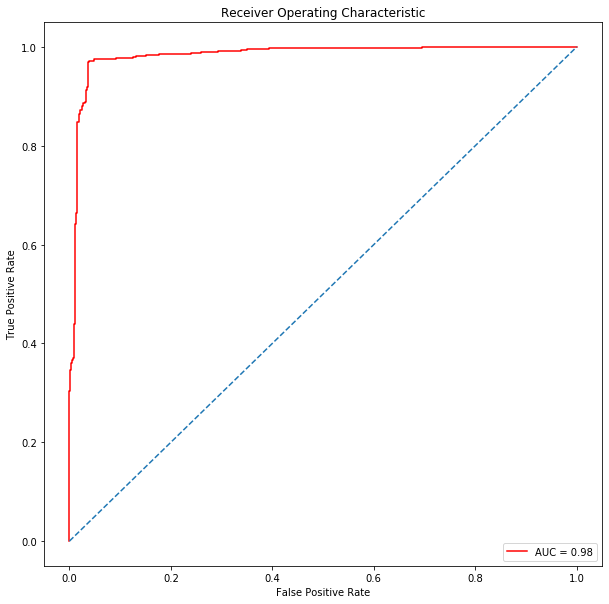

In [18]:
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

We obtain a nice first result of 0.982 results goodly assigned to the correct class.

## III - Improving the model

we are going to use the cross-validation model as always and moreover, as linear regression we can adjust some parameters.

In [19]:
lr = linear_model.LogisticRegression(solver = 'liblinear')
params = {'C': np.logspace(-2, 2, 20) , 'penalty':['l1','l2'] }
lr_gs = GridSearchCV(lr, params, cv=5)
lr_gs.fit(X_train, list(Y_train["class"]))

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.00...2,
       6.95192796e-02, 1.12883789e-01, 1.83298071e-01, 2.97635144e-01,
       4.83293024e-01, 7.84759970e-01, 1.27427499e+00, 2.06913808e+00,
       3.35981829e+00, 5.45559478e+00, 8.85866790e+00, 1.43844989e+01,
       2.33572147e+01, 3.79269019e+01, 6.15848211e+01, 1.00000000e+02]),
     

In [20]:
print(lr_gs.best_params_)

{'C': 100.0, 'penalty': 'l1'}


In [22]:
Y_predicted_probability = lr_gs.predict_proba(X_test)[:,1]
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, Y_predicted_probability)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc)

0.992546047146214


We obtain a really awesome rate of 0.992 good predictions. Which is clearly near to 100%.

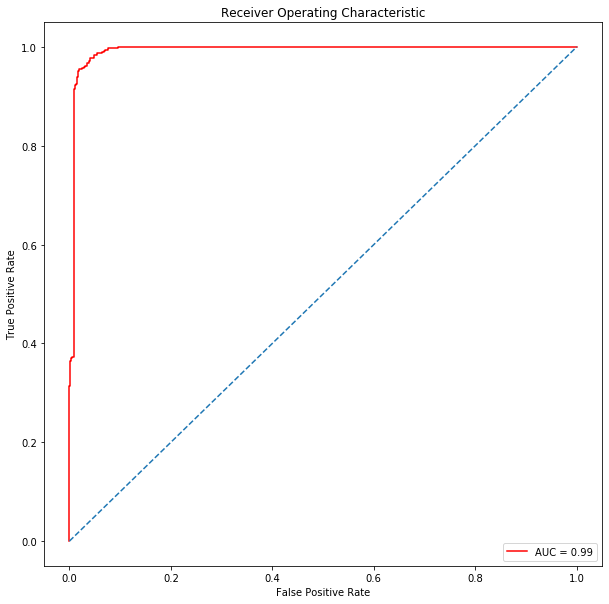

In [23]:
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## IV - A little further again ...

We can now try to use SWM linear models, in order to compare.

In [25]:
SVM = svm.LinearSVC()
params = {'C': np.logspace(-2, 2, 20)}
SVM_res = GridSearchCV(SVM, params, cv=5)
SVM_res.fit(X_train, list(Y_train["class"]))

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.00000000e-02, 1.62377674e-02, 2.63665090e-02, 4.28133240e-02,
       6.95192796e-02, 1.12883789e-01, 1.83298071e-01, 2.97635144e-01,
       4.83293024e-01, 7.84759970e-01, 1.27427499e+00, 2.06913808e+00,
       3.35981829e+00, 5.45559478e+00, 8.85866790e+00, 1.43844989e+01,
       2.33572147e+01, 3.79269019e+01, 6.15848211e+01, 1.00000000e+02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [28]:
print(SVM_res.best_params_)

{'C': 5.455594781168514}


In [29]:
Y_predicted_probability = SVM_res.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, Y_predicted_probability)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc)

0.9251269612673388


In this case, linear svm is worst than a good parametized logistic regression.